In [1]:
# Use !pip install ____ to install missing modules as needed

# Install pygbif for the GBIF download
!pip install pygbif

# Import the below libraries:
# To create reproducible file paths
from pathlib import Path
import os

# To login to GBIF
from getpass import getpass

# For the downloads
import csv
import requests
import tempfile
import time
import zipfile

# To work with different types of data
from glob import glob # To combine data arrays
from shapely.geometry import Point # To work with point geometries
import earthpy # To work with "canned" data
import geopandas as gpd # To make GeoDataFrames/work with vector data
import pandas as pd # To work with dataframes
import pygbif.occurrences as occ
import pygbif.species as species
import numpy as np # To work with arrays
import rasterio # To read raster data
import rioxarray as rxr # To work with raster data
import xarray as xr # To work with data arrays
 
# For interactive plotting
import matplotlib.pyplot as plt
import hvplot.pandas 
import hvplot.xarray
import holoviews as hv

/usr/local/python/3.12.1/lib/python3.12/site-packages/earthpy/__init__.py:7: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_string


In [2]:
# Create a directory to store the polyphemus moth occurrence data in
pm_data_dir = Path("polyphemus-moth-data-dir")
pm_data_dir.mkdir(parents=True, exist_ok=True)

In [3]:
# Login into GBIF
# Securely request and store GBIF username, password, and email address

reset_credentials = True

if (not ('GBIF_USER'  in os.environ)) or reset:
    os.environ['GBIF_USER'] = input('GBIF username:')

if (not ('GBIF_PWD'  in os.environ)) or reset:
    os.environ['GBIF_PWD'] = getpass('GBIF password:')
    
if (not ('GBIF_EMAIL'  in os.environ)) or reset:
    os.environ['GBIF_EMAIL'] = input('GBIF email:')

In [4]:
# Conduct a search query for the polyphemus moth
species_info = species.name_lookup('Antheraea polyphemus', rank='SPECIES')

# Obtain the first result
first_result = species_info['results'][0]

# List the species key
species_key = 1866570

# Print the results
first_result['species'], species_key

('Antheraea polyphemus', 1866570)

In [5]:
# Only download the data once
gbif_polyphemus_pattern = os.path.join(str(pm_data_dir), "**", "occurrence.txt")
if not glob(gbif_polyphemus_pattern):
    # Only submit one request
    if not 'GBIF_DOWNLOAD_KEY' in os.environ:
        # Submit query to GBIF
        gbif_query = occ.download([
        f"speciesKey = {species_key}",
        "hasCoordinate = True"
    ],
    format="DWCA"
)
    # Take the first result
    os.environ['GBIF_DOWNLOAD_KEY'] = gbif_query[0]

    # Wait for the download to build
    dld_key = os.environ['GBIF_DOWNLOAD_KEY']
    wait = occ.download_meta(dld_key)['status']
    while not wait=='SUCCEEDED':
        wait = occ.download_meta(dld_key)['status']
        time.sleep(5)

    # Download the GBIF data
    dld_info = occ.download_get(
    os.environ['GBIF_DOWNLOAD_KEY'], 
    path=pm_data_dir)
    dld_path = dld_info['path']

    # Unzip the GBIF data
    with zipfile.ZipFile(dld_path) as dld_zip:
        dld_zip.extractall(path=pm_data_dir)
                
    # Clean up the GBIF .zip file
    os.remove(dld_path)

    # Establish the path
    gbif_polyphemus_path = glob(gbif_polyphemus_pattern, recursive=True)[0]

INFO:Your download key is 0006912-251120083545085
INFO:Download file size: 14669196 bytes
INFO:On disk at polyphemus-moth-data-dir/0006912-251120083545085.zip


In [6]:
# Load the GBIF data
gbif_polyphemus_df = pd.read_csv(
    gbif_polyphemus_path,
    delimiter='\t',
        index_col='gbifID',
        usecols=['gbifID', 'eventDate','decimalLatitude', 'decimalLongitude']
)
gbif_polyphemus_df

,eventDate,decimalLatitude,decimalLongitude
gbifID,,,
923926047,2014-07-01T19:26:19,30.076778,-95.495178
923925493,2014-07-01T04:53:34,43.852963,-72.588778
923925071,2014-06-30T13:58:01,43.599196,-72.517297
923924387,2014-06-28T22:35:38,43.852963,-72.588778
923923819,2014-06-26T22:01:11,35.544423,-82.370604
...,...,...,...
1024184645,2014-07-02,44.285028,-72.573667
1024184438,2014-07-04T15:03:36,43.562679,-72.496800
1024182752,2014-06-11T12:38:08,46.137070,-89.891541


In [7]:
# Extract the month and year
gbif_polyphemus_df['eventDate'] = pd.to_datetime(gbif_polyphemus_df['eventDate'], errors='coerce')
gbif_polyphemus_df['month'] = gbif_polyphemus_df['eventDate'].dt.month
gbif_polyphemus_df['year'] = gbif_polyphemus_df['eventDate'].dt.year

#  Combine month and year into a single column
gbif_polyphemus_df['Month-Year'] = gbif_polyphemus_df['eventDate'].dt.to_period('M')

gbif_polyphemus_df.head()

,eventDate,decimalLatitude,decimalLongitude,month,year,Month-Year
gbifID,,,,,,
923926047,2014-07-01 19:26:19,30.076778,-95.495178,7.0,2014.0,2014-07
923925493,2014-07-01 04:53:34,43.852963,-72.588778,7.0,2014.0,2014-07
923925071,2014-06-30 13:58:01,43.599196,-72.517297,6.0,2014.0,2014-06
923924387,2014-06-28 22:35:38,43.852963,-72.588778,6.0,2014.0,2014-06
923923819,2014-06-26 22:01:11,35.544423,-82.370604,6.0,2014.0,2014-06


In [8]:
# Convert the GBIF data to a GeoDataFrame
# Input the longitude and latitude column names
gbif_gdf = (
    gpd.GeoDataFrame(
        gbif_polyphemus_df, 
        geometry=gpd.points_from_xy(
            gbif_polyphemus_df.decimalLongitude, 
            gbif_polyphemus_df.decimalLatitude), 
        crs="EPSG:4326")
    # Specify the desired columns
    [['Month-Year', 'geometry', 'decimalLatitude', 'decimalLongitude']]
)
gbif_gdf

,Month-Year,geometry,decimalLatitude,decimalLongitude
gbifID,,,,
923926047,2014-07,POINT (-95.49518 30.07678),30.076778,-95.495178
923925493,2014-07,POINT (-72.58878 43.85296),43.852963,-72.588778
923925071,2014-06,POINT (-72.5173 43.5992),43.599196,-72.517297
923924387,2014-06,POINT (-72.58878 43.85296),43.852963,-72.588778
923923819,2014-06,POINT (-82.3706 35.54442),35.544423,-82.370604
...,...,...,...,...
1024184645,NaT,POINT (-72.57367 44.28503),44.285028,-72.573667
1024184438,2014-07,POINT (-72.4968 43.56268),43.562679,-72.496800
1024182752,2014-06,POINT (-89.89154 46.13707),46.137070,-89.891541


In [9]:
# Remove data points with NaN values 
clean_gbif_gdf = gbif_gdf.dropna(subset=['Month-Year'])

clean_gbif_gdf

,Month-Year,geometry,decimalLatitude,decimalLongitude
gbifID,,,,
923926047,2014-07,POINT (-95.49518 30.07678),30.076778,-95.495178
923925493,2014-07,POINT (-72.58878 43.85296),43.852963,-72.588778
923925071,2014-06,POINT (-72.5173 43.5992),43.599196,-72.517297
923924387,2014-06,POINT (-72.58878 43.85296),43.852963,-72.588778
923923819,2014-06,POINT (-82.3706 35.54442),35.544423,-82.370604
...,...,...,...,...
1024192518,2014-07,POINT (-73.17825 43.60925),43.609253,-73.178253
1024184438,2014-07,POINT (-72.4968 43.56268),43.562679,-72.496800
1024182752,2014-06,POINT (-89.89154 46.13707),46.137070,-89.891541


<Axes: >

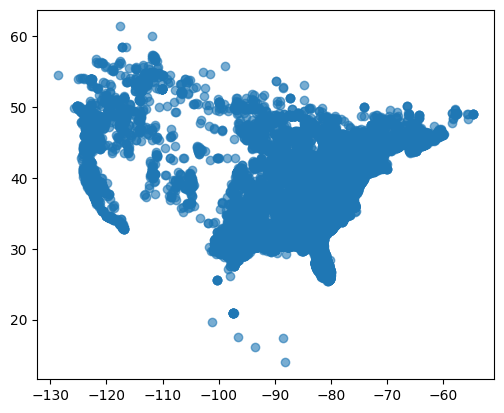

In [10]:
# Plot the points to check the data was processed successfully
clean_gbif_gdf.plot(
       alpha=0.6,
)

In [13]:
# Create a separate directory to store the light pollution data in
lp_data_dir = Path("light-pollution-data-dir")
lp_data_dir.mkdir(parents=True, exist_ok=True)

# Establish the light pollution data URL
lp_url = "https://datapub.gfz-potsdam.de/download/10.5880.GFZ.1.4.2016.001/World_Atlas_2015.zip"

# Create a path into the directory
lp_zip_path = Path(lp_data_dir/"World_Atlas_2015.zip")

# Download the data only once
if not lp_zip_path.exists():
     with requests.get(lp_url, stream=True) as r:
        r.raise_for_status()
        with open(lp_zip_path, "wb") as f:
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)

# Extract the zip file
with zipfile.ZipFile(lp_zip_path, 'r') as z:
    z.extractall(path=lp_data_dir)

In [ ]:
# Create a path for the tif file
lp_tif_path = Path(lp_data_dir/"World_Atlas_2015.tif")

# Load the tif file as a data array
lp_da = rxr.open_rasterio(lp_tif_path, masked=True).squeeze("band", drop=True)

# Print the data array's crs and shape
print(lp_da.rio.crs, lp_da.shape)

EPSG:4326 (17406, 43200)


In [16]:
lp_da.head()

<xarray.DataArray (y: 5, x: 5)> Size: 100B
[25 values with dtype=float32]
Coordinates:
  * y            (y) float64 40B 85.05 85.04 85.03 85.03 85.02
  * x            (x) float64 40B -180.0 -180.0 -180.0 -180.0 -180.0
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [19]:
lp_da.hvplot(
    geo=True,
    cmap='viridis',
    alpha=0.6,
    title='Light Pollution'
)

: 